# Tugas Kecil IF3170 Inteligensi Buatan

Anggota Kelompok:
1. Kevin John Wesley Hutabarat (13521042)
2. Jericho Russel Sebastian (13521107)

In [19]:
import pandas as pd
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fmt

In [3]:
# Pembacaan data
data = pd.read_csv("data/data_train.csv")
data.columns = data.columns.str.strip()

In [4]:
# Ukuran data
data.shape

(1400, 21)

In [5]:
# Head data
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0


In [6]:
# Definisi kelas-kelas pembantu
STATS_VERTICAL_VIEW = True
ROUNDING_LIMIT = 3

class BaseStatistics(ABC):
    def __init__(self, col_name: str) -> None:
        self.col = data[col_name]
        self.mean = self.col.mean()
        self.median = self.col.median()
        self.mode = self._calc_mode()
        self.std = self.col.std()
        self.var = self.col.var()
        self.max = self.col.max()
        self.min = self.col.min()
    
    def range(self) -> float:
        return self.max - self.min
    
    def stats(self) -> pd.DataFrame:
        return pd.DataFrame({
            'Name': ['Mean', 'Median', 'Mode', 'Standard deviation', 'Variance', 'Range', 'Minimum value', 'Maximum value'],
            'Value': [round(self.mean, ROUNDING_LIMIT), self.median, self.mode, round(self.std, ROUNDING_LIMIT), round(self.var, ROUNDING_LIMIT), round(self.range(), ROUNDING_LIMIT), self.min, self.max]
        }) if STATS_VERTICAL_VIEW else pd.DataFrame({
            'Mean': [round(self.mean, ROUNDING_LIMIT)],
            'Median': [self.median],
            'Mode': [self.mode],
            'Standard deviation': [round(self.std, ROUNDING_LIMIT)],
            'Variance': [round(self.var, ROUNDING_LIMIT)],
            'Range': [round(self.range(), ROUNDING_LIMIT)],
            'Minimum value': [self.min],
            'Maximum value': [self.max]
        })
    
    @abstractmethod
    def visualize(self) -> None:
        pass

    @abstractmethod
    def _calc_mode(self) -> float:
        pass

    def __repr__(self) -> str:
        return (
            f'Mean = {round(self.mean, ROUNDING_LIMIT)}\n'
            f'Median = {self.median}\n'
            f'Mode = {self.mode}\n'
            f'Standard deviation = {round(self.std, ROUNDING_LIMIT)}\n'
            f'Variance = {round(self.var, ROUNDING_LIMIT)}\n'
            f'Range = {round(self.range(), ROUNDING_LIMIT)}\n'
            f'Minimum value = {self.min}\n'
            f'Maximum value = {self.max}'
        )


In [21]:
class NumericStatistics(BaseStatistics):
    def __init__(self, col_name: str) -> None:
        super().__init__(col_name)
        self.q4 = [q for q in self.col.quantile([.25, .5, .75]).to_list()]
        self.skew = self.col.skew()
        self.kurt = self.col.kurt()
    
    def iqr(self) -> float:
        return self.q4[2] - self.q4[0]
    
    def stats(self) -> pd.DataFrame:
        stats_df = super().stats()
        if STATS_VERTICAL_VIEW:
            stats_df.loc[len(stats_df.index)] = ['Q1', round(self.q4[0], ROUNDING_LIMIT)]
            stats_df.loc[len(stats_df.index)] = ['Q2', round(self.q4[1], ROUNDING_LIMIT)]
            stats_df.loc[len(stats_df.index)] = ['Q3', round(self.q4[2], ROUNDING_LIMIT)]
            stats_df.loc[len(stats_df.index)] = ['IQR', round(self.iqr(), ROUNDING_LIMIT)]
            stats_df.loc[len(stats_df.index)] = ['Skewness', round(self.skew, ROUNDING_LIMIT)]
            stats_df.loc[len(stats_df.index)] = ['Kurtosis', round(self.kurt, ROUNDING_LIMIT)]
        else:
            row = stats_df.loc[0].to_dict()
            row['Q1'] = [round(self.q4[0], ROUNDING_LIMIT)]
            row['Q2'] = [round(self.q4[1], ROUNDING_LIMIT)]
            row['Q3'] = [round(self.q4[2], ROUNDING_LIMIT)]
            row['IQR'] = [round(self.iqr(), ROUNDING_LIMIT)]
            row['Skewness'] = [round(self.skew, ROUNDING_LIMIT)]
            row['Kurtosis'] = [round(self.kurt, ROUNDING_LIMIT)]
            stats_df = pd.DataFrame(row)
        return stats_df
    
    def _create_group_table(self):
        intv_count = self.col.count() #Banyak data
        intv_length = (self.col.max() - self.col.min()) / intv_count #Panjang kelas

        temp = [[] for _ in range(intv_count)] #Inisialisasi tabel pengelompokan data

        #Assign nilai sesuai dengan kelompoknya
        for d in self.col.to_list():
            idx = int((d - self.col.min()) / intv_length)
            if idx == intv_count: 
                idx -= 1
            temp[idx].append(d) 
            
        return temp, intv_length

    def _create_freq_table(self):
        #Inisialisasi tabel pengelompokan data
        tempg, intv_length = self._create_group_table()
        temp = [len(x) for x in tempg] #Membuat tabel frekuensi
        return temp, intv_length
    
    def visualize(self, intv_count) -> None: #plot
        fig, axs = plt.subplots(2, 1)
        fig.set_size_inches(12,8)

        #Histogram

        #Boxplot
        _ = axs[1].boxplot(self.col, vert=False)
    
    def _calc_mode(self) -> float:
        #Mencari modus untuk data berkelompok
        intv_count = self.col.count()

        #Inisialisasi tabel frekuensi
        temp, intv_length = self._create_freq_table()

        idx = temp.index(max(temp)) #Mengambil indeks dengan frekuensi terbesar
        l = (self.col.min() + idx * intv_length) #tepi bawah kelas modus
        d1 = 0 if idx == 0 else temp[idx] - temp[idx - 1] #selisih frekuensi kelas modus dengan frekuensi kelas sebelumnya
        d2 = 0 if idx == intv_count - 1 else temp[idx] - temp[idx + 1] #selisih frekuensi kelas modus dengan frekuensi kelas setelahnya
            
        mode = l + intv_length * d1 / (d1 + d2) #Menghitung modus
        return mode

    def __repr__(self) -> str:
        return (
            f'{super().__repr__()}\n'
            f'Quartile = {[round(q, ROUNDING_LIMIT) for q in self.q4]}\n'
            f'IQR = {round(self.iqr(), ROUNDING_LIMIT)}\n'
            f'Skewness = {round(self.skew, ROUNDING_LIMIT)}\n'
            f'Kurtosis = {round(self.kurt, ROUNDING_LIMIT)}'
        )

In [8]:
class NonnumericStatistics(BaseStatistics):
    def visualize(self) -> None: #histogram
        fig, ax = plt.subplots()
        fig.set_size_inches(8,3)

        _, bins, _ = ax.hist(self.col, bins=2, edgecolor='white')
        ax.set_xticks(bins)

    def _calc_mode(self) -> float:
        self.freq_table = {}
        for d in self.col.to_list():
            if d in self.freq_table.keys():
                self.freq_table[d] += 1
            else:
                self.freq_table[d] = 1
        (curr_mode, max_f) = (None, -1)
        for d in self.freq_table:
            if self.freq_table[d] > max_f:
                (curr_mode, max_f) = (d, self.freq_table[d])
        return curr_mode

## Analisis Data

### Battery Power

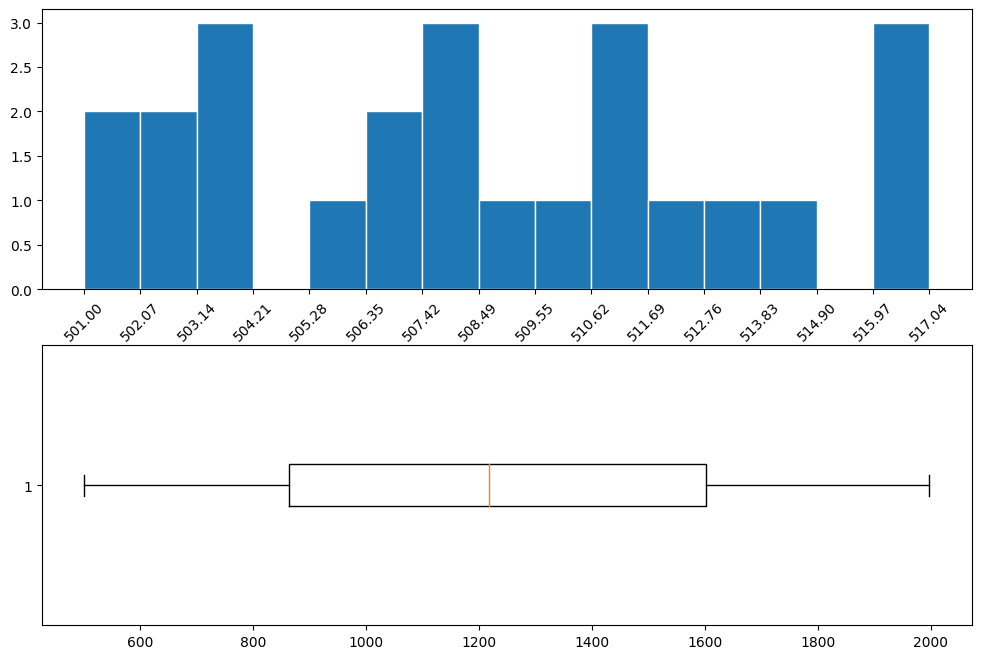

In [22]:
NumericStatistics('battery_power').stats()
NumericStatistics('battery_power').visualize(15)

### Blue

In [10]:
NonnumericStatistics('blue').stats()

,Name,Value
0,Mean,0.494
1,Median,0.000
2,Mode,0.000
3,Standard deviation,0.500
4,Variance,0.250
5,Range,1.000
6,Minimum value,0.000
7,Maximum value,1.000


In [11]:
#Duplicate Value

In [12]:
#Missing Value

In [13]:
#Outlier

In [14]:
#Distribusi Data dan Histogram

In [15]:
#Korelasi dengan Kolom Target